In [238]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Simulated Automated Market Maker (AMM)

We simulate an AMM to swap between two token equipped with a constant product market maker (CPMM). Let $x$ be the number of stable coin (DAI) and $y$ be the number of crypto (ETH). CPMM means that there exists $k$ such that 

$$
x\cdot y =k
$$

Assume that the initial price of token $Y$ is $\pi^Y_0 = \$500$ while the price for token $X$ is constant equal to $\$1$. The first Liquidity Provider (LP) supply $\$10,000$ worth of each asset to the pool.

|| Price | Supplied | Value|
|-----|-------|----------|---------|
| DAI |1|10,000|10,000|
| ETH |500|20| 10,000|  

We have $k = 20,000$. The price of token $Y$ is given by $\pi^Y_0 = x / y = 500$ and the initial liquidity is given by $L = \sqrt{x\cdot y}$ (this is the geometric mean of the number of units of token $X$ and $Y$.

We add two features, the ability to swap one token for the other and the ability to add lquidity to the pool. 

1. I want to get $dy$ quantity of $Y$ so I must add $dx = \frac{x\cdot dy}{y-dy}$
2. I want to increase the liquidity of the pool by providing $\$5000$, I need to provide $\$2500$ worth of each token. We then write a function to add liquidity where $dx = 2500$ units of token $X$ is provided, so we must provide $dy = \frac{y}{x}dx$ 




In [239]:
class AMM:

    def __init__(self, x, y, fee_rate=0.3):
        self.x = x # Units of token X
        self.y = y # Units of token Y
        k = x * y
        self.k = k # Constant k
        self.π = x / y # Price of Y (X is the numeraire)
        self.L = [np.sqrt(k)] # Measure of Liquidity
        self.fee_rate = fee_rate # Liquidity Providers' cut on each swap transaction
        self.LP = ["LP1"] # Id of Liquidity Providers
        self.weights = [1]
        self.fee_collected = np.array([0]) # Fee accumulated by the pool
        

    def swap_x_for_y(self, dy):
        res = copy.deepcopy(self)
        res.x = self.x + self.x * dy / (self.y - dy)
        res.y = self.y - dy
        res.π = res.x / res.y 
        res.fee_collected = self.fee_collected + np.array(self.weights) * self.fee_rate * self.x * dy / (self.y - dy)
        return(res)
        
    def swap_y_for_x(self, dx):
        res = copy.deepcopy(self)
        res.y = self.y + self.y * dx / (self.x - dx)
        res.x = self.x - dx
        res.π = res.x / res.y 
        res.fee_collected = self.fee_collected + np.array(self.weights) * self.fee_rate * dx
        return(res)
    
    def add_liquidity(self, dx, new_LP, which_LP):
        res = copy.deepcopy(self)
        dy = self.y / self.x * dx
        res.y = self.y + dy
        res.x = self.x + dx
        res.k = res.y * res.x # Constant k
        res.π = res.x / res.y # Price of Y (X is the numeraire)

        if new_LP:
            res.LP.append("LP"+str(len(self.LP)+1))
            res.L.append(np.sqrt(dx*dy))
            res.weights = res.L/(sum(res.L))
            res.fee_collected = np.append(res.fee_collected, 0)
        else:
            res.L[np.where(np.array(res.LP) == which_LP)[0][0]] += np.sqrt(dx*dy)  
            res.weights = res.L/(sum(res.L))
        return(res)
        
    def __str__(self):
        return "The state of the AMM is" + \
    "\nNumber of token X: " + str(self.x) + \
    "\nNumber of token Y: " + str(self.y) + \
    "\nConstant k: " + str(self.k) + \
    "\nPrice of Y: " + str(self.π)  + \
    "\nAmount of Liquidity: " + str(sum(self.L))  +\
    "\nNumber of Liquidity provider: " + str(self.LP)  + \
    "\nWeights of Liquidity provider: " + str(self.weights)  + \
    "\nFees collected by LPs: " + str(self.fee_collected) + "\n--------------"

Let us see what goes on in the pool when we take $dy$ of the $Y$ token from the pool.  

In [241]:
AMM_0 = AMM(10000, 20)
print(AMM_0)
AMM_after_swap = AMM_0.swap_x_for_y(2)
print(AMM_after_swap)
# AMM_back_to_normal = AMM_after_swap.swap_y_for_x(AMM_after_swap.x-AMM_0.x)
# print(AMM_back_to_normal)

The state of the AMM is
Number of token X: 10000
Number of token Y: 20
Constant k: 200000
Price of Y: 500.0
Amount of Liquidity: 447.21359549995793
Number of Liquidity provider: ['LP1']
Weights of Liquidity provider: [1]
Fees collected by LPs: [0]
--------------
The state of the AMM is
Number of token X: 11111.111111111111
Number of token Y: 18
Constant k: 200000
Price of Y: 617.283950617284
Amount of Liquidity: 447.21359549995793
Number of Liquidity provider: ['LP1']
Weights of Liquidity provider: [1]
Fees collected by LPs: [333.33333333]
--------------


Swap trades occurs along thee curve $y = k / x$

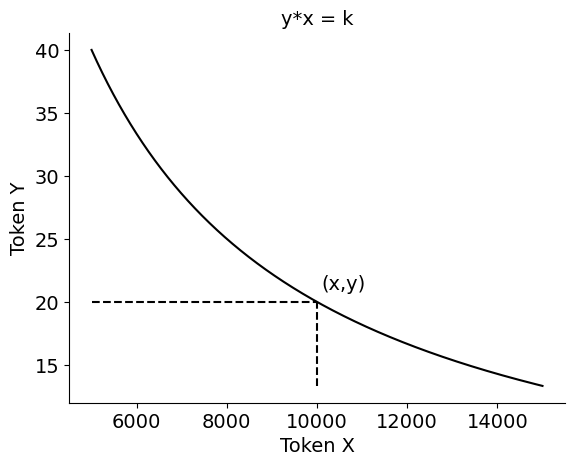

In [137]:
k = AMM_0.k

plt.plot(np.arange(5000, 15000 ,1), k / np.arange(5000, 15000 ,1),
         color = 'k', alpha = 1, linestyle ='solid', label = 'y = k / x')
plt.xlabel('Token X', fontsize = 14)
plt.ylabel('Token Y', fontsize = 14)
plt.title('y*x = k', fontsize = 14)
plt.vlines(x=10000, ymin=k/15000, ymax=20, color = 'k', linestyle = '--',alpha = 1)
plt.hlines(y=20, xmin=5000, xmax=10000, color = 'k', linestyle = '--', alpha = 1)
plt.text(10100, 21, "(x,y)", fontsize = 14)
plt.tick_params(labelsize=14)
sns.despine()
plt.savefig('../../Figures/AMM_initial.pdf')

After the swap trade we move on the curve like so

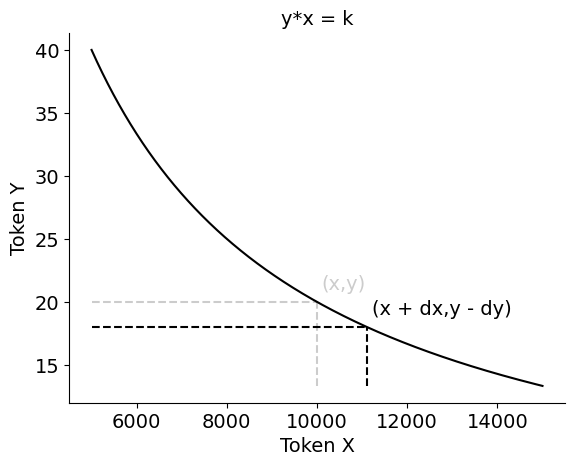

In [113]:
k = AMM_0.k

plt.plot(np.arange(5000, 15000 ,1), k / np.arange(5000, 15000 ,1),
         color = 'k', alpha = 1, linestyle ='solid', label = 'y = k / x')
plt.xlabel('Token X', fontsize = 14)
plt.ylabel('Token Y', fontsize = 14)
plt.title('y*x = k', fontsize = 14)
plt.vlines(x=10000, ymin=k/15000, ymax=20, color = 'k', linestyle = '--',alpha = 0.2)
plt.hlines(y=20, xmin=5000, xmax=10000, color = 'k', linestyle = '--', alpha = 0.2)
plt.vlines(x=AMM_after_swap.x, ymin=k/15000, ymax=AMM_after_swap.y, color = 'k', linestyle = '--',alpha = 1)
plt.hlines(y=AMM_after_swap.y, xmin=5000, xmax=AMM_after_swap.x, color = 'k', linestyle = '--', alpha = 1)
plt.text(10100, 21, "(x,y)", fontsize = 14, alpha = 0.2)
plt.text(AMM_after_swap.x + 100, AMM_after_swap.y+ 1, "(x + dx,y - dy)", fontsize = 14)
plt.tick_params(labelsize=14)
sns.despine()
plt.savefig('../../Figures/AMM_after_swap.pdf')

Let see now what goes on in the pool when we add some liquidity

In [114]:
# Here we have a new comer LP2 that add 2500 units of token X
dx, new_LP, which_LP = 2500, True, "LP2"
AMM_after_drop = AMM_0.add_liquidity(dx, new_LP, which_LP)
print(AMM_after_drop)

# Now LP2 consolidates her position by providing more liquidity
dx, new_LP, which_LP = 2500, False, "LP2"
AMM_after_drop2 = AMM_after_drop.add_liquidity(dx, new_LP, which_LP)
print(AMM_after_drop2)

The state of the AMM is
Number of token X: 12500
Number of token Y: 25.0
Constant k: 312500.0
Price of Y: 500.0
Amount of Liquidity: 559.0169943749474
Number of Liquidity provider: ['LP1', 'LP2']
Weights of Liquidity provider: [0.8 0.2]
Fees collected by LPs: [0 0]
--------------
The state of the AMM is
Number of token X: 15000
Number of token Y: 30.0
Constant k: 450000.0
Price of Y: 500.0
Amount of Liquidity: 670.8203932499368
Number of Liquidity provider: ['LP1', 'LP2']
Weights of Liquidity provider: [0.66666667 0.33333333]
Fees collected by LPs: [0 0]
--------------


After adding liquidity we change the level of the curve from $k$ to 
$$
k' = (x+dx)\cdot (y+dy)
$$

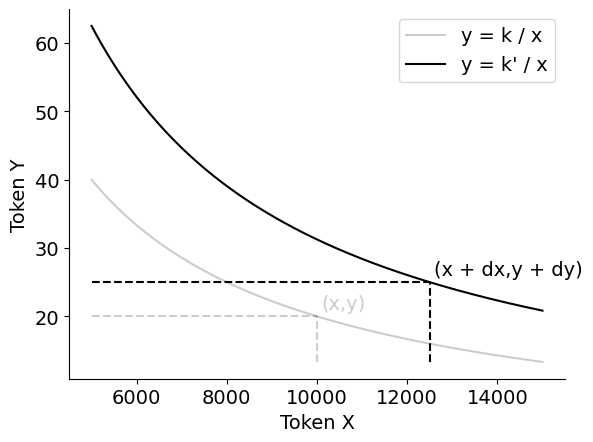

In [138]:
plt.plot(np.arange(5000, 15000 ,1), AMM_0.k / np.arange(5000, 15000 ,1),
         color = 'k', alpha = 0.2, linestyle ='solid', label = 'y = k / x')
plt.plot(np.arange(5000, 15000 ,1), AMM_after_drop.k / np.arange(5000, 15000 ,1),
         color = 'k', alpha = 1, linestyle ='solid', label = "y = k' / x")

# plt.title('y*x = k', fontsize = 14)

plt.vlines(x=10000, ymin=AMM_0.k/15000, ymax=20, color = 'k', linestyle = '--',alpha = 0.2)
plt.hlines(y=20, xmin=5000, xmax=10000, color = 'k', linestyle = '--', alpha = 0.2)

plt.vlines(x=AMM_after_drop.x, ymin=AMM_0.k/15000, ymax=AMM_after_drop.y, color = 'k', linestyle = '--',alpha = 1)
plt.hlines(y=AMM_after_drop.y, xmin=5000, xmax=AMM_after_drop.x, color = 'k', linestyle = '--', alpha = 1)

plt.text(10100, 21, "(x,y)", fontsize = 14, alpha = 0.2)
plt.text(AMM_after_drop.x + 100, AMM_after_drop.y +1, "(x + dx,y + dy)", fontsize = 14, alpha = 1)

plt.xlabel('Token X', fontsize = 14)
plt.ylabel('Token Y', fontsize = 14)
plt.tick_params(labelsize=14)
plt.legend(fontsize = 14)
sns.despine()
plt.savefig('../../Figures/AMM_after_drop.pdf')

Liquidity providers are exposed to the risk of unpermanent loss. This is the loss incurred when locking ones asset instead of holding them. Assume that th price of ETH to $\$550$ on other trading venues. Arbitrageurs will come to the pool to buy ETH.

How many ETH are being bought taking into account the price variation linked to the trade and the trading fee? 

Fisrt how many ETH can be bought so the price of ETH reaches $P' = 550$ in the pool (considering the state of the AMM after LP2 enters the game). We have 
$$
P' = \frac{x+dx}{y-dy}\Leftrightarrow dy = \frac{\sqrt{P'}y-\sqrt{k}}{\sqrt{P'}}
$$
after multiplying both sides by $(y-dy)^2$. Then of course 
$$
dx = \frac{xdy}{y-dy}
$$

let use apply this trade!

In [223]:
P_new = 550
print(AMM_0)
AMM_after_arb = AMM_0.swap_x_for_y(AMM_0.y - np.sqrt(AMM_0.k) / np.sqrt(P_new))
print(AMM_after_arb)


The state of the AMM is
Number of token X: 10000
Number of token Y: 20
Constant k: 200000
Price of Y: 500.0
Amount of Liquidity: 447.21359549995793
Number of Liquidity provider: ['LP1']
Weights of Liquidity provider: [1]
Fees collected by LPs: [0]
--------------
The state of the AMM is
Number of token X: 10488.088481701516
Number of token Y: 19.069251784911845
Constant k: 200000
Price of Y: 550.0
Amount of Liquidity: 447.21359549995793
Number of Liquidity provider: ['LP1']
Weights of Liquidity provider: [1]
Fees collected by LPs: [4.88088482]
--------------


The arbitageurs profit is 

In [224]:
P_new * (AMM_0.y - AMM_after_arb.y) - (AMM_after_arb.x - AMM_0.x), AMM_0.y - AMM_after_arb.y

(23.82303659696936, 0.9307482150881548)

The LP impermanent loss is given by the diffece in worth between holding and locking the assets in the the pool. We have

In [225]:
P_new * (AMM_0.y) + AMM_0.x - (P_new * AMM_after_arb.y + AMM_after_arb.x)

23.82303659696845

### The presence of trading fee $\alpha$ (here 0.3) mitigates this impermanent loss as the arbitrageurs aims at maximizing
$$
\underset{dy}{\max} P'dy - dx(1+\alpha) = \underset{dy}{\max} P'dy - \frac{x dy}{y - dy}(1+\alpha) = \underset{dy}{\max} f(dy)
$$

we have that 
$$
f'(dy) = 0 \Rightarrow dy = y - \sqrt{\frac{K(1+\alpha)}{P'}}
$$

and $f''(dy)<0$.

In [230]:
α = 0.05
AMM_0 = AMM(10000, 20, α)
print(AMM_0)
AMM_after_arb = AMM_0.swap_x_for_y(max(AMM_0.y - np.sqrt(AMM_0.k * (1+AMM_0.fee_rate) / P_new), 0))
print(AMM_after_arb)


The state of the AMM is
Number of token X: 10000
Number of token Y: 20
Constant k: 200000
Price of Y: 500.0
Amount of Liquidity: 447.21359549995793
Number of Liquidity provider: ['LP1']
Weights of Liquidity provider: [1]
Fees collected by LPs: [0]
--------------
The state of the AMM is
Number of token X: 10235.32631438318
Number of token Y: 19.540168418367887
Constant k: 200000
Price of Y: 523.8095238095239
Amount of Liquidity: 447.21359549995793
Number of Liquidity provider: ['LP1']
Weights of Liquidity provider: [1]
Fees collected by LPs: [11.76631572]
--------------


The arbitrageur's profit now becomes

In [231]:
P_new * (AMM_0.y - AMM_after_arb.y) - (AMM_after_arb.x - AMM_0.x) * (1 + AMM_0.fee_rate)

5.814739795323817

The impermanent loss is

In [232]:
P_new * (AMM_0.y) + AMM_0.x - (P_new * AMM_after_arb.y + AMM_after_arb.x + (AMM_after_arb.x - AMM_0.x ) * AMM_0.fee_rate)

5.814739795325295

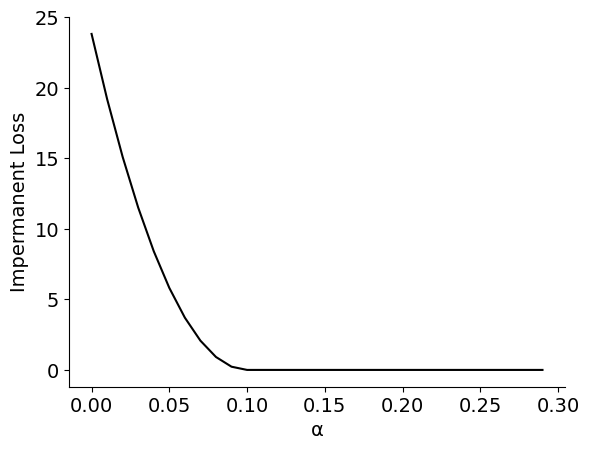

In [237]:
αs = np.arange(0, 0.3, 0.01)
imp_loss = []
for α in αs:
    AMM_0 = AMM(10000, 20, α)
    AMM_after_arb = AMM_0.swap_x_for_y(max(AMM_0.y - np.sqrt(AMM_0.k * (1+AMM_0.fee_rate) / P_new), 0))
    imp_loss.append(P_new * (AMM_0.y) + AMM_0.x - (P_new * AMM_after_arb.y + AMM_after_arb.x + (AMM_after_arb.x - AMM_0.x ) * AMM_0.fee_rate))
    

plt.plot(αs, imp_loss,color = 'k', alpha = 1, linestyle ='solid')
plt.xlabel('α', fontsize = 14)
plt.ylabel('Impermanent Loss', fontsize = 14)
plt.tick_params(labelsize=14)

sns.despine()
plt.savefig('../../Figures/imp_loss.pdf')